In [533]:
CUDA_VISIBLE_DEVICES=""


In [71]:
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
pd.set_option('display.max_columns', 500)
import sys, os
from sklearn.linear_model import LogisticRegression
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [452]:
tf.random.set_seed(42)

In [30]:
from derm7pt.dataset import Derm7PtDataset, Derm7PtDatasetGroupInfrequent
from derm7pt.vis import plot_confusion
from derm7pt.kerasutils import deep_features

In [3]:
# CHANGE THIS LINE TO YOUR DATA DIRECTORY.
dir_release = "D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0"
dir_meta = os.path.join(dir_release, 'meta')
dir_images = os.path.join(dir_release, 'images')

In [4]:
meta_df = pd.read_csv(os.path.join(dir_meta, 'meta.csv'))
train_indexes = list(pd.read_csv(os.path.join(dir_meta, 'train_indexes.csv'))['indexes'])
valid_indexes = list(pd.read_csv(os.path.join(dir_meta, 'valid_indexes.csv'))['indexes'])
test_indexes = list(pd.read_csv(os.path.join(dir_meta, 'test_indexes.csv'))['indexes'])

In [5]:
# The full dataset before any grouping of the labels.
derm_data = Derm7PtDataset(dir_images=dir_images, 
                        metadata_df=meta_df.copy(), # Copy as is modified.
                        train_indexes=train_indexes, valid_indexes=valid_indexes, 
                        test_indexes=test_indexes)

# The dataset after grouping infrequent labels.
derm_data_group = Derm7PtDatasetGroupInfrequent(dir_images=dir_images, 
                                             metadata_df=meta_df.copy(), # Copy as is modified.
                                             train_indexes=train_indexes, 
                                             valid_indexes=valid_indexes, 
                                             test_indexes=test_indexes)

In [6]:
derm_data.dataset_stats()

Number of cases: 1011
Number of cases to train: 413
Number of cases to validate: 203
Number of cases to test: 395


### START--

In [7]:
derm_data.df.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes,diagnosis_numeric,pigment_network_numeric,blue_whitish_veil_numeric,vascular_structures_numeric,pigmentation_numeric,streaks_numeric,dots_and_globules_numeric,regression_structures_numeric
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN,0,0,0,1,0,0,0,0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN,0,0,0,0,0,0,2,0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN,0,0,0,1,0,0,2,0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN,0,0,1,4,0,0,2,1
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN,0,0,0,0,3,0,0,0


In [8]:
derm_data.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   case_num                        1011 non-null   int64 
 1   diagnosis                       1011 non-null   object
 2   seven_point_score               1011 non-null   int64 
 3   pigment_network                 1011 non-null   object
 4   streaks                         1011 non-null   object
 5   pigmentation                    1011 non-null   object
 6   regression_structures           1011 non-null   object
 7   dots_and_globules               1011 non-null   object
 8   blue_whitish_veil               1011 non-null   object
 9   vascular_structures             1011 non-null   object
 10  level_of_diagnostic_difficulty  1011 non-null   object
 11  elevation                       1011 non-null   object
 12  location                        1011 non-null   

In [9]:
derm_data.df['diagnosis'].unique(), len(derm_data.df['diagnosis'].unique())

(array(['basal cell carcinoma', 'blue nevus', 'clark nevus',
        'combined nevus', 'congenital nevus', 'dermal nevus',
        'dermatofibroma', 'lentigo', 'melanoma (in situ)',
        'melanoma (less than 0.76 mm)', 'melanoma (0.76 to 1.5 mm)',
        'melanoma (more than 1.5 mm)', 'melanoma metastasis', 'melanosis',
        'miscellaneous', 'recurrent nevus', 'reed or spitz nevus',
        'seborrheic keratosis', 'vascular lesion', 'melanoma'],
       dtype=object),
 20)

Similar medical interpretation labels are grouped together.
- in term derm_data.df, only different types of melanoma are grouped together under the abbrev MEL
- in derm_data_group.df, other DIAGNOSIS are also grouped.
- 7 point checkpoints are grouped in derm_data_group BUT not in derm_data.

In [10]:
derm_data.df['diagnosis_numeric'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

### -- END

In [11]:
# Converted the meta-data to categorical (*_numeric) labels.
derm_data_group.df.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes,diagnosis_numeric,pigment_network_numeric,blue_whitish_veil_numeric,vascular_structures_numeric,pigmentation_numeric,streaks_numeric,dots_and_globules_numeric,regression_structures_numeric
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN,0,0,0,1,0,0,0,0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN,0,0,0,0,0,0,2,0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN,0,0,0,1,0,0,2,0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN,0,0,1,1,0,0,2,1
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN,0,0,0,0,2,0,0,0


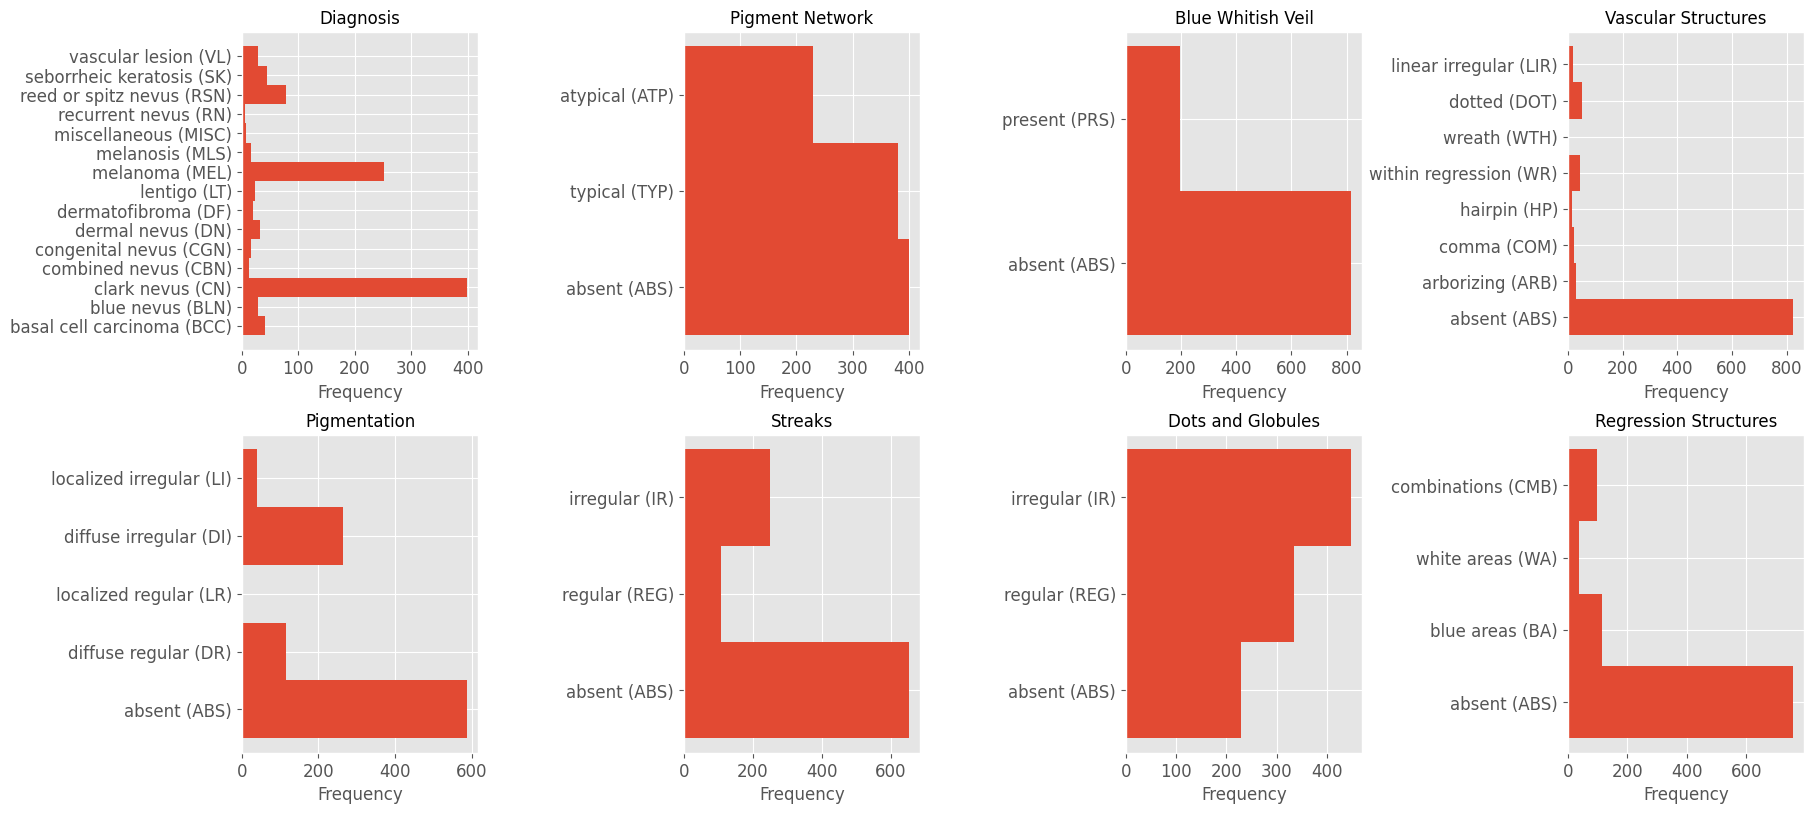

In [12]:
# Distribution of the labels before any grouping (most granular labels).
derm_data.plot_tags_hist(figsize=(18,8), fontsize=12)

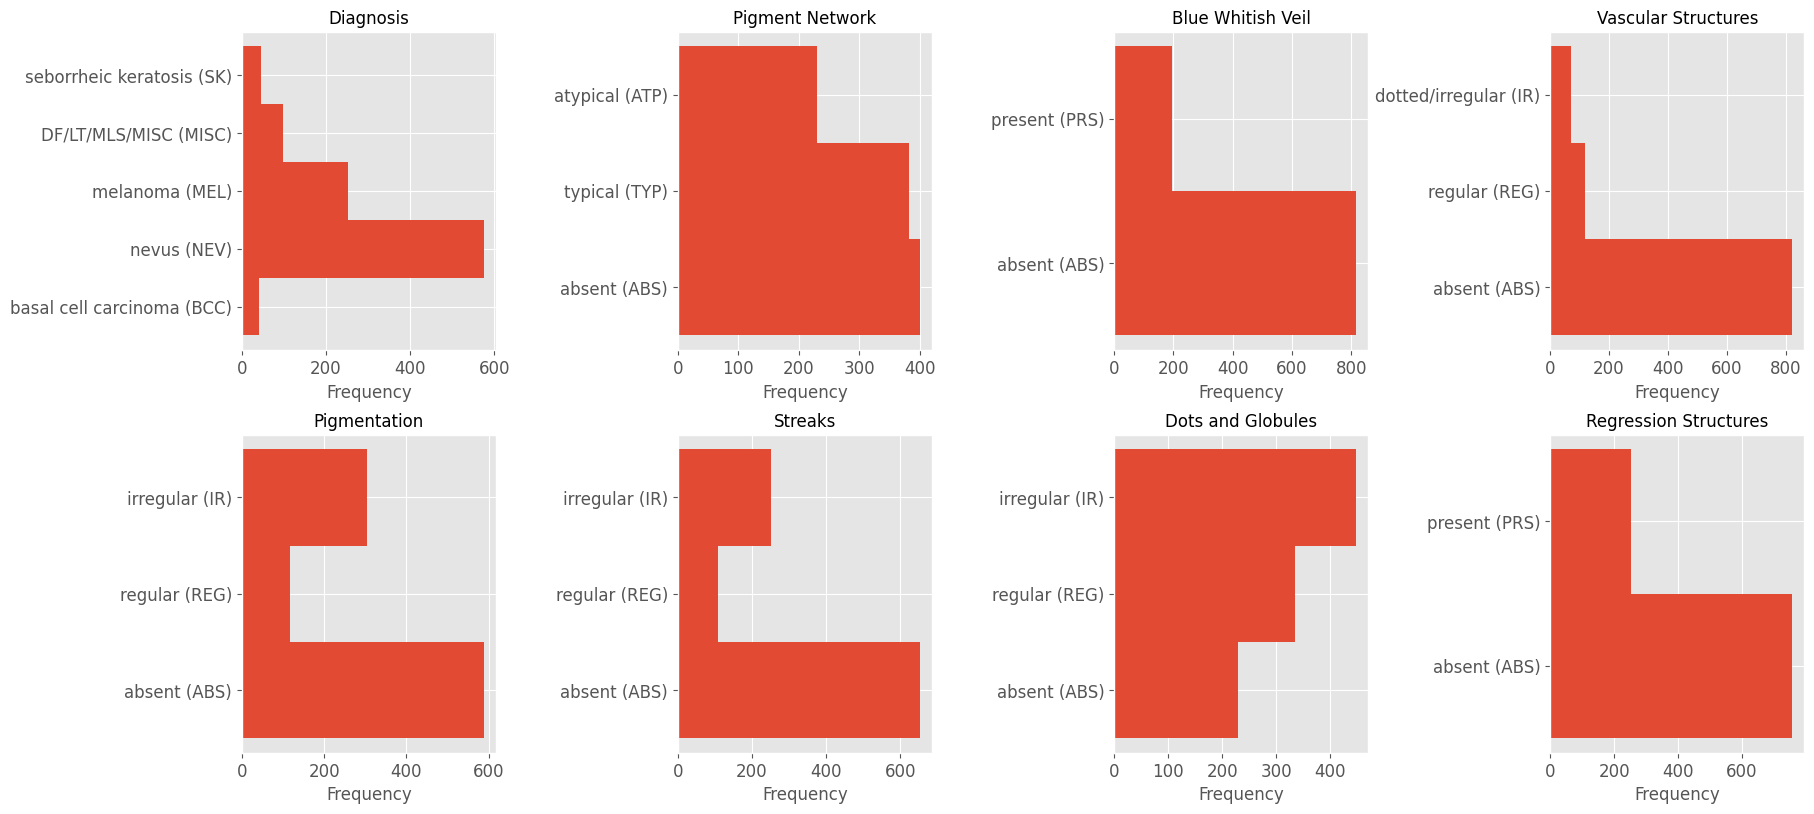

In [13]:
# Distribution of the labels after the grouping.
# We group some clinicially labels as many granular labels occur very infrequently.
derm_data_group.plot_tags_hist(figsize=(18,8), fontsize=12)

case_num                                              70
diagnosis                                     blue nevus
seven_point_score                                      0
pigment_network                                   absent
streaks                                           absent
pigmentation                             diffuse regular
regression_structures                             absent
dots_and_globules                                 absent
blue_whitish_veil                                 absent
vascular_structures                               absent
level_of_diagnostic_difficulty                       low
elevation                                        nodular
location                                     lower limbs
sex                                               female
management                        no further examination
clinic                                    Fgl/Fgl049.jpg
derm                                      Fgl/Fgl090.jpg
case_id                        

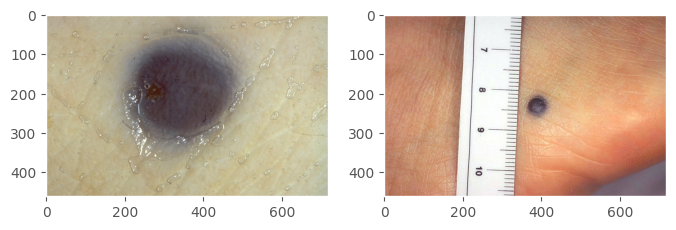

In [14]:
# Show the derm and clinical image for a single case.
row_index = 69
derm = derm_data_group.derm_image(row_index=row_index)
clinic = derm_data_group.clinic_image(row_index=row_index)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(derm)
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(clinic)
plt.grid(False)
# Show the corresponding info.
print(derm_data_group.df.iloc[row_index])

<h1>Example using Deep Features and a Linear Model</h1>

In [15]:
# Get the dermatology and clinic training images and corresponding labels.
train_derm_paths = derm_data_group.get_img_paths(data_type='train', img_type='derm')
train_clinic_paths = derm_data_group.get_img_paths(data_type='train', img_type='clinic')
train_labels = derm_data_group.get_labels(data_type='train', one_hot=False)

# The 8 abbreviations that indicate the different types of categories 
# i.e., 1 diagnosis + 7 critera.
print(train_labels.keys())

dict_keys(['DIAG', 'PN', 'BWV', 'VS', 'PIG', 'STR', 'DaG', 'RS'])


In [16]:
# Get the dermatology and clinic test images and corresponding labels.
test_derm_paths = derm_data_group.get_img_paths(data_type='test', img_type='derm')
test_clinic_paths = derm_data_group.get_img_paths(data_type='test', img_type='clinic')
test_labels = derm_data_group.get_labels(data_type='test', one_hot=False)

In [17]:
# Note, you can get images for validation by:
valid_derm_paths = derm_data_group.get_img_paths(data_type='valid', img_type='derm')
valid_clinic_paths = derm_data_group.get_img_paths(data_type='valid', img_type='clinic')
valid_labels = derm_data_group.get_labels(data_type='valid', one_hot=False)
print(len(valid_derm_paths))
# We don't use them within this demo, but they could/should be used when choosing hyper-parameters.

203


### START---

In [18]:
train_labels.keys()

dict_keys(['DIAG', 'PN', 'BWV', 'VS', 'PIG', 'STR', 'DaG', 'RS'])

In [19]:
(train_labels)

{'DIAG': 16     0
 17     0
 22     0
 27     0
 29     0
       ..
 950    4
 977    4
 981    3
 983    3
 988    3
 Name: diagnosis_numeric, Length: 413, dtype: int32,
 'PN': 16     0
 17     0
 22     0
 27     0
 29     0
       ..
 950    2
 977    1
 981    0
 983    0
 988    0
 Name: pigment_network_numeric, Length: 413, dtype: int32,
 'BWV': 16     1
 17     0
 22     1
 27     0
 29     0
       ..
 950    0
 977    0
 981    0
 983    0
 988    0
 Name: blue_whitish_veil_numeric, Length: 413, dtype: int32,
 'VS': 16     1
 17     2
 22     1
 27     1
 29     1
       ..
 950    0
 977    0
 981    0
 983    0
 988    0
 Name: vascular_structures_numeric, Length: 413, dtype: int32,
 'PIG': 16     0
 17     2
 22     0
 27     0
 29     0
       ..
 950    0
 977    2
 981    1
 983    1
 988    0
 Name: pigmentation_numeric, Length: 413, dtype: int32,
 'STR': 16     2
 17     0
 22     0
 27     0
 29     0
       ..
 950    0
 977    0
 981    0
 983    0
 988    0
 Name: 

In [20]:
type(train_labels['DIAG']), train_labels['DIAG'].shape

(pandas.core.series.Series, (413,))

In [21]:
train_labels['DIAG'].unique()

array([0, 1, 3, 2, 4])

In [22]:
train_derm_paths

['D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\NFL/Nfl068.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\NGL/Ngl047.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\NML/Nml106.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\Ael/Ael505.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\Gzl/gzl06.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\FCL/Fcl062.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\NFL/Nfl046.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\NML/Nml089.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\Gzl/gzl88.jpg',
 'D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0\\images\\FAL/Fal012.jpg',
 'D:/COLLEGE/PROJECTS/

In [23]:
temp_train = derm_data_group.get_labels(data_type='train', one_hot=True)
temp_test = derm_data_group.get_labels(data_type='test', one_hot=True)
temp_valid = derm_data_group.get_labels(data_type='valid', one_hot=True)

In [24]:
type(temp_train['DIAG']), temp_train['DIAG'].shape

(numpy.ndarray, (413, 5))

### ---END

In [508]:
# Choose a pretrained model to extract features from.
# Can use any model. Just have to make sure the input_shape is appropriate.
import tensorflow as tf
# from keras.applications.mobilenet import preprocess_input
# from keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
input_shape = (224, 224, 3)
# model = MobileNetV2(include_top=False, input_shape=input_shape)
model = InceptionV3(include_top=False, input_shape=input_shape)

In [399]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 255, 255, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 255, 255, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

In [28]:
# Apply cropping around the boundary of the images to get rid of the black boundary.
crop_amount= 25

<h2>Extract features from dermatology images</h2>

In [400]:
# Extract features from training images (might take a few minutes... ideally you have a GPU.)
train_derm_f = deep_features(img_paths=train_derm_paths, model=model, 
                             func_preprocess_input=preprocess_input, 
                             target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 45ms/step


In [401]:
valid_derm_f = deep_features(img_paths=valid_derm_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 41ms/step


In [402]:
# Extract features from testing images (might take a few minutes)
test_derm_f = deep_features(img_paths=test_derm_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 76ms/step


In [403]:
# Number_of_images x number_of_features 
print(train_derm_f.shape) # 413 images. 
print(test_derm_f.shape) # 395 images.

(413, 2048)
(395, 2048)


<h2>Extract features from clinical images</h2>

In [404]:
# May take a bit of time.
train_clinic_f = deep_features(img_paths=train_clinic_paths, model=model, 
                               func_preprocess_input=preprocess_input, 
                               target_size=input_shape, crop_amount=crop_amount)

valid_clinic_f = deep_features(img_paths=valid_clinic_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

test_clinic_f = deep_features(img_paths=test_clinic_paths, model=model, 
                              func_preprocess_input=preprocess_input, 
                              target_size=input_shape, crop_amount=crop_amount)


1/1 [==============================] - 0s 39ms/step


In [405]:
print(train_clinic_f.shape)
print(valid_clinic_f.shape)
print(test_clinic_f.shape)

(413, 2048)
(203, 2048)
(395, 2048)


### START--- (using deep_features())

In [406]:
idx_to_class = {
    0: 'BCC', 1: 'NEV', 2: 'MEL', 3: 'MISC', 4: 'SK'
}

In [407]:
class_to_idx = {
    'BCC': 0, 'NEV': 1, 'MEL': 2, 'MISC': 3, 'SK': 4
}

In [408]:
ip_shape = (train_clinic_f.shape[1], )

In [459]:
mm = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=ip_shape),
    # tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5)
])

In [460]:
mm.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_43 (Flatten)        (None, 2048)              0         
                                                                 
 dense_141 (Dense)           (None, 128)               262272    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_142 (Dense)           (None, 128)               16512     
                                                                 
 dense_143 (Dense)           (None, 5)                 645       
                                                                 
Total params: 279,429
Trainable params: 279,429
Non-trainable params: 0
_________________________________________________________________


In [461]:
mm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [462]:
# train_labels['DIAG']

In [463]:
history = mm.fit(train_derm_f, train_labels['DIAG'], validation_data = (valid_derm_f, valid_labels['DIAG']), epochs=100)


Epoch 1/100
13/13 [==============================] - 1s 20ms/step - loss: 1.1843 - accuracy: 0.6029 - val_loss: 1.3037 - val_accuracy: 0.4926
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 1.0529 - accuracy: 0.6029 - val_loss: 1.2011 - val_accuracy: 0.5320
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 0.9677 - accuracy: 0.6659 - val_loss: 1.1699 - val_accuracy: 0.5665
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 0.8766 - accuracy: 0.6731 - val_loss: 1.1367 - val_accuracy: 0.5764
Epoch 5/100
13/13 [==============================] - 0s 10ms/step - loss: 0.8113 - accuracy: 0.6852 - val_loss: 1.2394 - val_accuracy: 0.5567
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 0.7501 - accuracy: 0.7119 - val_loss: 1.0806 - val_accuracy: 0.5862
Epoch 7/100
13/13 [==============================] - 0s 14ms/step - loss: 0.7172 - accuracy: 0.7385 - val_loss: 1.0871 - val_accuracy: 0.5714
Epoch 8

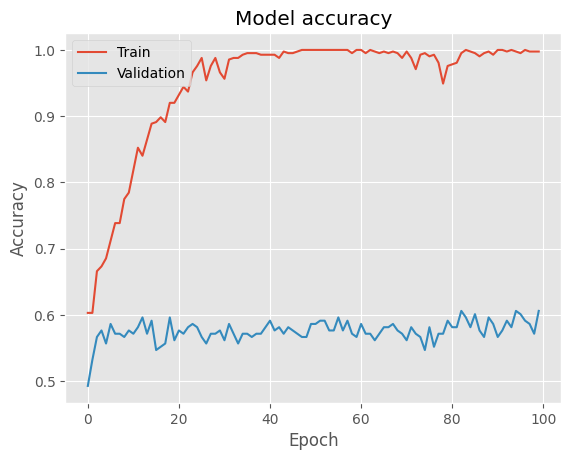

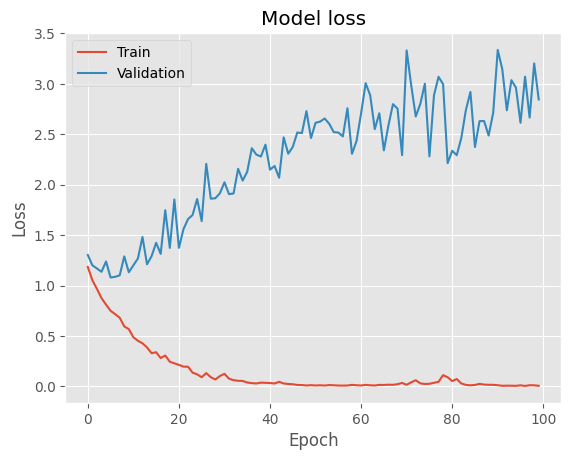

In [464]:
# Plotting accuracy values of the train and validation sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting loss values of the train and validation sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [465]:
test_loss, test_acc = mm.evaluate(test_derm_f, test_labels['DIAG'], verbose=2)

print('\nTest accuracy:', test_acc)

13/13 - 0s - loss: 2.2324 - accuracy: 0.6582 - 64ms/epoch - 5ms/step

Test accuracy: 0.6582278609275818


In [170]:
# mm.save("weird.h5")

In [466]:
probability_model = tf.keras.Sequential([mm, 
                                         tf.keras.layers.Softmax()])

In [467]:
predictions = probability_model.predict(test_derm_f)


13/13 [==============================] - 0s 2ms/step


In [468]:
predictions[0]

array([0.00330917, 0.01456212, 0.01216785, 0.95437014, 0.01559079],
      dtype=float32)

In [469]:
np.argmax(predictions[0])


3

In [470]:
test_labels['DIAG'].iloc[0]

0

In [471]:
def plot_image(i, predictions_array, true_label, img):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(idx_to_class[predicted_label],
                                100*np.max(predictions_array),
                                idx_to_class[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [472]:
import matplotlib.image as mpimg

In [473]:
# plt.imshow(mpimg.imread(test_derm_paths[0]))

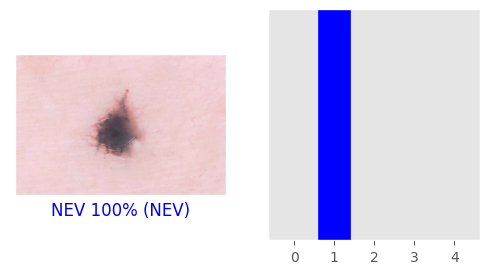

In [474]:
i = 111
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels['DIAG'].reset_index(drop = True), mpimg.imread(test_derm_paths[i]))
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels['DIAG'].reset_index(drop = True))
plt.show()

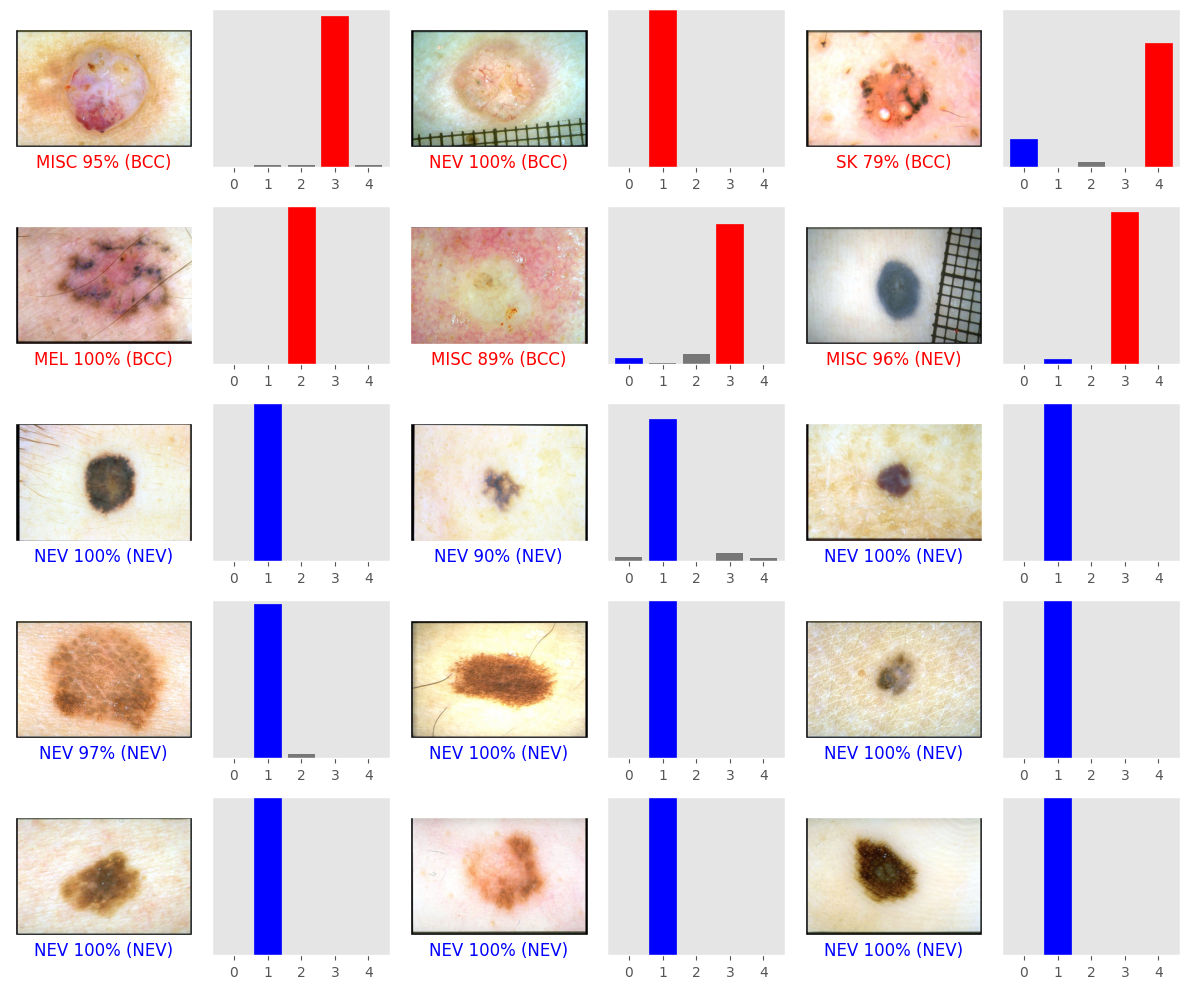

In [475]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels['DIAG'].reset_index(drop = True), mpimg.imread(test_derm_paths[i]))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels['DIAG'].reset_index(drop = True))
plt.tight_layout()
plt.show()

In [476]:
test_temp = []
for i in predictions:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [477]:
label_names = derm_data_group.get_label_by_abbrev('DIAG').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


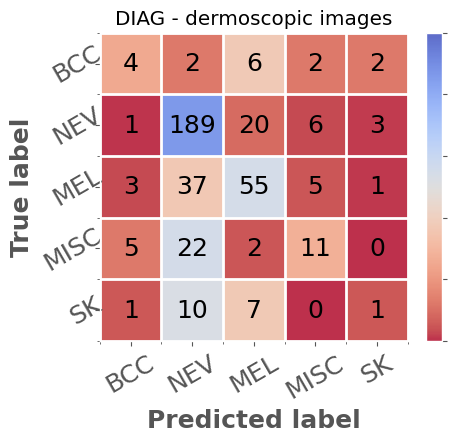

In [478]:
plot_confusion(y_true=test_labels['DIAG'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('DIAG' + ' - dermoscopic images');

### ---END

### --START (without using deep_features())

In [523]:
type(train_derm_paths)

list

In [524]:
tt = []
for i, j in enumerate(train_derm_paths):
    tt.append(derm_data_group.derm_image(i, crop_amount=crop_amount, target_size = input_shape))

In [529]:
tt = np.array(tt)
tt.shape

(413, 224, 224, 3)

In [530]:
tt[0].shape

(224, 224, 3)

In [537]:
abc = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    classes=5,
    classifier_activation='softmax',
)

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [512]:
abc.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1955 (Conv2D)           (None, 111, 111, 32  864         ['input_34[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_1955 (Batc  (None, 111, 111, 32  96         ['conv2d_1955[0][0]']            
 hNormalization)                )                                                      

In [527]:
abc.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [532]:
with tf.device('/CPU:0'):
    history = abc.fit(tt, train_labels['DIAG'], epochs=100)


Epoch 1/100


TypeError: 'NoneType' object is not callable

### ---END (without using deep_features())

<h2>Train a linear model on the images</h2>

In [222]:
# Select one of the categories.
abbrev = 'DIAG'
# These are the labels associated with the given abbreviation.
label_names = derm_data_group.get_label_by_abbrev(abbrev).abbrevs.values

In [225]:
label_names

array(['BCC', 'NEV', 'MEL', 'MISC', 'SK'], dtype=object)

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36:

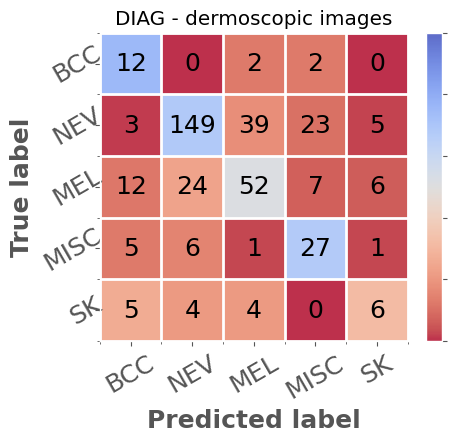

In [42]:
# Linear classifier for derm images.
reg = LogisticRegression(C=0.01, class_weight='balanced').fit(train_derm_f, train_labels[abbrev])

# Make predictions.
test_preds = reg.predict(test_derm_f)

# Display a confusion matrix.
plot_confusion(y_true=test_labels[abbrev], y_pred=test_preds, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images');

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36:

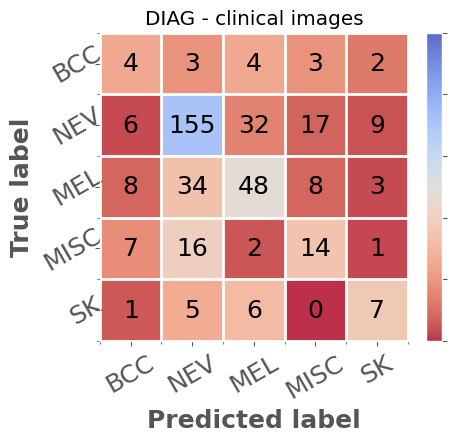

In [ ]:
# Linear classifier on clinic images. 
reg = LogisticRegression(C=0.01, class_weight='balanced').fit(train_clinic_f, train_labels[abbrev])
test_preds = reg.predict(test_clinic_f)
# Performance is worse for clinical images as they are less standardized than derm images.
plot_confusion(y_true=test_labels[abbrev], y_pred=test_preds, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - clinical images');

c:\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36:

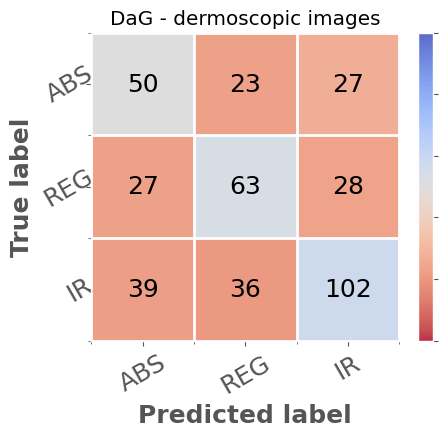

In [ ]:
# Example with category "Dots and Globules" using derm images.
abbrev = 'DaG'
reg = LogisticRegression(C=0.01, class_weight='balanced').fit(train_derm_f, train_labels[abbrev])
test_preds = reg.predict(test_derm_f)
label_names = derm_data_group.get_label_by_abbrev(abbrev).abbrevs.values
plot_confusion(y_true=test_labels[abbrev], y_pred=test_preds, labels=label_names, figsize=(6,4))
plt.title(abbrev + ' - dermoscopic images');